<a href="https://colab.research.google.com/github/davidsonsantana89/dass--CESAR_SCHOOL-Topicos_Contemporaneos/blob/main/exercicios/dass_05_Improving_the_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DAVIDSON ALVES SANTOS DE SANTANA

dass@cesar.school

In [1]:
# Importando as bibliotecas necessárias
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

In [2]:
# Download do dataset MNIST into data dir
! wget https://pjreddie.com/media/files/mnist_train.csv -P data

--2024-08-26 23:58:58--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [text/csv]
Saving to: ‘data/mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M  32.2MB/s    in 3.8s    

2024-08-26 23:59:02 (27.8 MB/s) - ‘data/mnist_train.csv’ saved [109575994/109575994]



In [3]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file, header=None)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # A primeira coluna é o rótulo
        label = self.data.iloc[idx, 0]
        # As demais colunas são os pixels da imagem
        image = self.data.iloc[idx, 1:].values.astype('uint8').reshape(28, 28)

        if self.transform:
            image = self.transform(image)

        return image, label

In [4]:
# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

# Transformação para converter a imagem para tensor
transform = transforms.Compose([
    transforms.ToPILImage(),    # Convertendo o array numpy para imagem PIL
    transforms.ToTensor(),      # Convertendo a imagem PIL para tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalizando a imagem
])

# Criando o dataset
mnist_dataset = MNISTDataset("./data/mnist_train.csv", transform=transform)

In [5]:
# Criando índices aleatórios para os subsets de treino e teste
np.random.seed(42)
indices = np.arange(len(mnist_dataset))
np.random.shuffle(indices)

# Dividindo os índices em trainset e testset
num_train = 1000
num_val = 500
num_test = 500
train_indices = indices[:num_train]  # Primeiros 1.000 índices para o trainset
val_indices = indices[num_train:num_train+num_val]  # Próximos 500 índices para o valset
test_indices = indices[num_train+num_val:num_train+num_val+num_test]  # Mais 500 para o testset

trainset = Subset(mnist_dataset, train_indices)
valset = Subset(mnist_dataset, val_indices)
testset = Subset(mnist_dataset, test_indices)

# Criando DataLoaders para os subsets
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

In [6]:
def train_model(model, trainloader, valloader, criterion, optimizer, num_epochs=5):
    history = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': []
    }

    for epoch in range(num_epochs):
        # Treinamento
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in tqdm(enumerate(trainloader, 0), total=len(trainloader)):
            inputs, labels = data

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        history['train_losses'].append(train_loss)
        history['train_accuracies'].append(train_acc)
        print(f'Epoch {epoch+1}, Train Loss: {train_loss:.3f}, Train Accuracy: {train_acc:.2f}%')

        # Validação
        model.eval()
        val_running_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                inputs, labels = data
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_running_loss / len(valloader)
        val_acc = 100 * correct / total
        history['val_losses'].append(val_loss)
        history['val_accuracies'].append(val_acc)
        print(f'Epoch {epoch+1}, Val Loss: {val_loss:.3f}, Val Accuracy: {val_acc:.2f}%')

    print('Treinamento concluído')
    return history


def test_model(model, testloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Acurácia da rede na base de teste: {100 * correct / total:.2f}%')

In [48]:
class CNN(nn.Module):
    def __init__(self, initialize_weights=True, dropout=0.2, num_filters_1=6, num_filters_2=12, num_neurons=64):
        super(CNN, self).__init__()
        self.num_filters_2 = num_filters_2
        self.conv1 = nn.Conv2d(1, num_filters_1, 5)
        self.conv2 = nn.Conv2d(num_filters_1, num_filters_2, 5)
        self.fc1 = nn.Linear(num_filters_2 * 4 * 4, num_neurons)
        self.fc2 = nn.Linear(num_neurons, 10)
        self.dropout = nn.Dropout(dropout)

        if initialize_weights:
            self._initialize_weights()

    def forward(self, x):
        # CNN
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)

        # Flatten
        x = x.view(-1, self.num_filters_2 * 4 * 4)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)

        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

In [11]:
model = CNN(
    initialize_weights=True,
    dropout=0.2
)

In [9]:
model = CNN(
    initialize_weights=False,
    dropout=0.2
)

In [10]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [12]:
# Treinando a CNN
history = train_model(
    model=model,
    trainloader=trainloader,
    valloader=valloader,
    criterion=criterion,
    optimizer=optimizer
)

100%|██████████| 16/16 [00:01<00:00, 10.37it/s]


Epoch 1, Train Loss: 2.453, Train Accuracy: 9.80%
Epoch 1, Val Loss: 2.422, Val Accuracy: 14.20%


100%|██████████| 16/16 [00:01<00:00, 13.17it/s]


Epoch 2, Train Loss: 2.442, Train Accuracy: 10.60%
Epoch 2, Val Loss: 2.422, Val Accuracy: 14.20%


100%|██████████| 16/16 [00:01<00:00, 13.69it/s]


Epoch 3, Train Loss: 2.451, Train Accuracy: 10.60%
Epoch 3, Val Loss: 2.422, Val Accuracy: 14.20%


100%|██████████| 16/16 [00:01<00:00, 12.16it/s]


Epoch 4, Train Loss: 2.453, Train Accuracy: 10.90%
Epoch 4, Val Loss: 2.422, Val Accuracy: 14.20%


100%|██████████| 16/16 [00:01<00:00, 12.32it/s]


Epoch 5, Train Loss: 2.450, Train Accuracy: 10.60%
Epoch 5, Val Loss: 2.422, Val Accuracy: 14.20%
Treinamento concluído


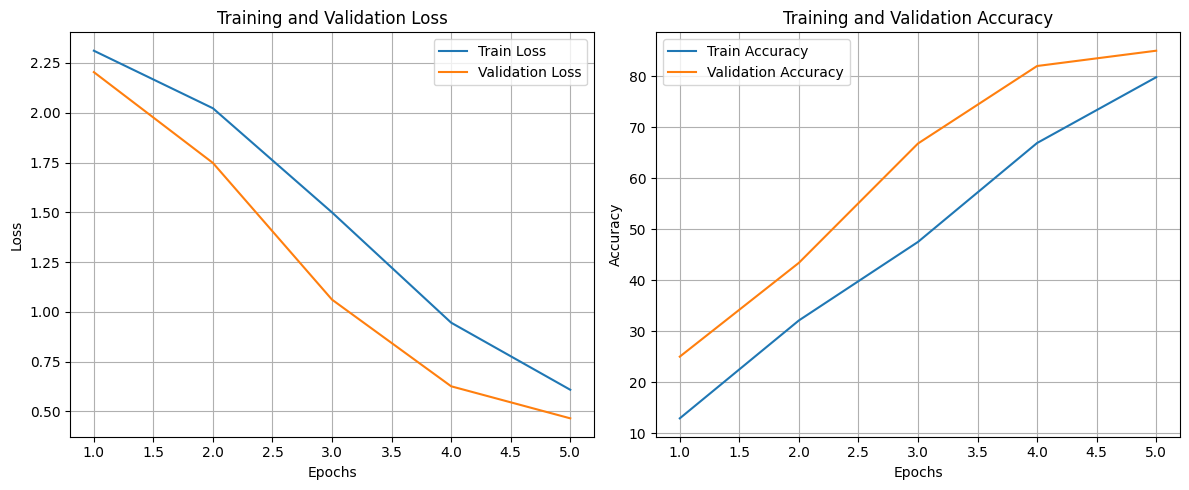

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 89.40%


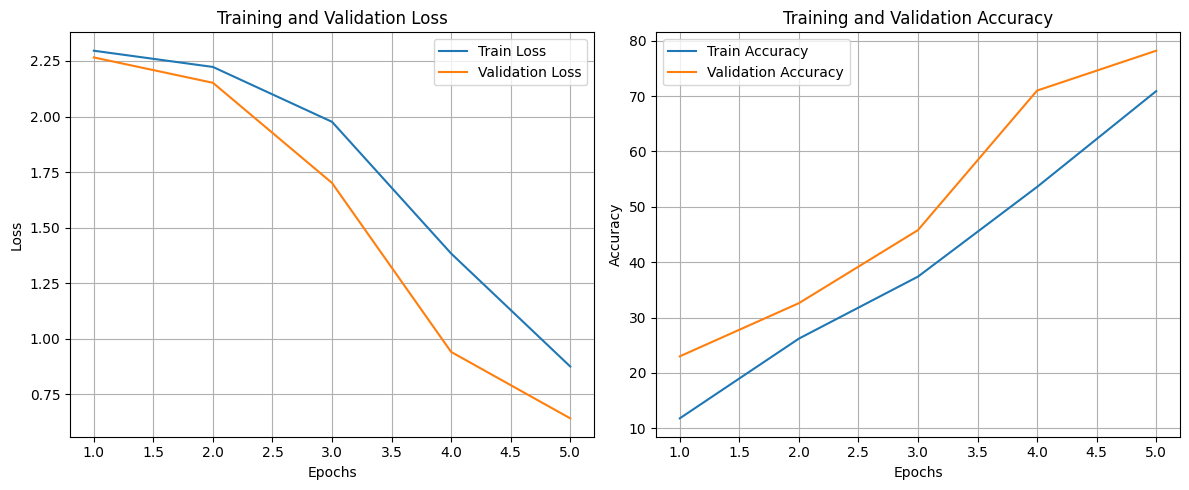

In [ ]:
epochs = range(1, len(history['train_losses']) + 1)

# Plot de losses
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.grid()
plt.plot(epochs, history['train_losses'], label='Train Loss')
plt.plot(epochs, history['val_losses'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot de accuracies
plt.subplot(1, 2, 2)
plt.grid()
plt.plot(epochs, history['train_accuracies'], label='Train Accuracy')
plt.plot(epochs, history['val_accuracies'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
test_model(model, testloader)

Acurácia da rede na base de teste: 83.80%


## Exercícios

### Exercício 1
Na CNN implementada, execute experimentos variando:
- O número de filtros convolucionais em `self.conv1` (6 e 8)
- O número de filtros convolucionais em `self.conv2` (12 e 16)

Ao final, observe qual combinação desempenha melhor no conjunto de testes.

Dica: Adicionar argumentos no construtor da classe para determinar o número de filtros em cada camada pode ser útil para inicializar diversos modelos.

In [57]:
combinacoes_parametros = [(2*k, 4*m) for k in range(3, 5) for m in range(3, 5)]


for num_filters_1, num_filters_2 in combinacoes_parametros:
    print(f"Treinamento com {num_filters_1} filtros na primeira camada e {num_filters_2} filtros na segunda camada")
    model = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_filters_1=num_filters_1,
        num_filters_2=num_filters_2
        )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    # Treinando a CNN
    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    test_model(model, testloader)
    print()



Treinamento com 6 filtros na primeira camada e 12 filtros na segunda camada


100%|██████████| 16/16 [00:00<00:00, 21.31it/s]


Epoch 1, Train Loss: 2.289, Train Accuracy: 15.70%
Epoch 1, Val Loss: 2.218, Val Accuracy: 28.80%


100%|██████████| 16/16 [00:00<00:00, 20.87it/s]


Epoch 2, Train Loss: 2.070, Train Accuracy: 33.50%
Epoch 2, Val Loss: 1.764, Val Accuracy: 49.60%


100%|██████████| 16/16 [00:00<00:00, 20.53it/s]


Epoch 3, Train Loss: 1.384, Train Accuracy: 56.10%
Epoch 3, Val Loss: 0.799, Val Accuracy: 77.60%


100%|██████████| 16/16 [00:00<00:00, 19.85it/s]


Epoch 4, Train Loss: 0.809, Train Accuracy: 73.40%
Epoch 4, Val Loss: 0.552, Val Accuracy: 84.00%


100%|██████████| 16/16 [00:00<00:00, 20.66it/s]


Epoch 5, Train Loss: 0.536, Train Accuracy: 82.70%
Epoch 5, Val Loss: 0.416, Val Accuracy: 86.80%
Treinamento concluído
Acurácia da rede na base de teste: 88.80%

Treinamento com 6 filtros na primeira camada e 16 filtros na segunda camada


100%|██████████| 16/16 [00:01<00:00, 14.22it/s]


Epoch 1, Train Loss: 2.293, Train Accuracy: 15.20%
Epoch 1, Val Loss: 2.213, Val Accuracy: 28.00%


100%|██████████| 16/16 [00:01<00:00, 13.94it/s]


Epoch 2, Train Loss: 2.065, Train Accuracy: 31.60%
Epoch 2, Val Loss: 1.770, Val Accuracy: 49.00%


100%|██████████| 16/16 [00:01<00:00, 14.97it/s]


Epoch 3, Train Loss: 1.358, Train Accuracy: 56.50%
Epoch 3, Val Loss: 0.781, Val Accuracy: 77.40%


100%|██████████| 16/16 [00:00<00:00, 20.62it/s]


Epoch 4, Train Loss: 0.805, Train Accuracy: 73.50%
Epoch 4, Val Loss: 0.524, Val Accuracy: 84.60%


100%|██████████| 16/16 [00:00<00:00, 20.56it/s]


Epoch 5, Train Loss: 0.529, Train Accuracy: 82.20%
Epoch 5, Val Loss: 0.407, Val Accuracy: 88.40%
Treinamento concluído
Acurácia da rede na base de teste: 88.80%

Treinamento com 8 filtros na primeira camada e 12 filtros na segunda camada


100%|██████████| 16/16 [00:00<00:00, 20.71it/s]


Epoch 1, Train Loss: 2.296, Train Accuracy: 16.10%
Epoch 1, Val Loss: 2.200, Val Accuracy: 33.80%


100%|██████████| 16/16 [00:00<00:00, 18.87it/s]


Epoch 2, Train Loss: 2.030, Train Accuracy: 35.20%
Epoch 2, Val Loss: 1.691, Val Accuracy: 51.20%


100%|██████████| 16/16 [00:00<00:00, 19.64it/s]


Epoch 3, Train Loss: 1.305, Train Accuracy: 58.30%
Epoch 3, Val Loss: 0.744, Val Accuracy: 78.40%


100%|██████████| 16/16 [00:00<00:00, 20.60it/s]


Epoch 4, Train Loss: 0.719, Train Accuracy: 75.70%
Epoch 4, Val Loss: 0.477, Val Accuracy: 85.20%


100%|██████████| 16/16 [00:00<00:00, 20.59it/s]


Epoch 5, Train Loss: 0.483, Train Accuracy: 84.80%
Epoch 5, Val Loss: 0.399, Val Accuracy: 89.40%
Treinamento concluído
Acurácia da rede na base de teste: 90.20%

Treinamento com 8 filtros na primeira camada e 16 filtros na segunda camada


100%|██████████| 16/16 [00:00<00:00, 20.14it/s]


Epoch 1, Train Loss: 2.241, Train Accuracy: 18.60%
Epoch 1, Val Loss: 2.112, Val Accuracy: 24.60%


100%|██████████| 16/16 [00:01<00:00, 14.27it/s]


Epoch 2, Train Loss: 1.827, Train Accuracy: 38.80%
Epoch 2, Val Loss: 1.440, Val Accuracy: 56.60%


100%|██████████| 16/16 [00:01<00:00, 12.45it/s]


Epoch 3, Train Loss: 1.111, Train Accuracy: 62.80%
Epoch 3, Val Loss: 0.787, Val Accuracy: 74.40%


100%|██████████| 16/16 [00:00<00:00, 17.87it/s]


Epoch 4, Train Loss: 0.698, Train Accuracy: 75.40%
Epoch 4, Val Loss: 0.484, Val Accuracy: 83.40%


100%|██████████| 16/16 [00:00<00:00, 20.55it/s]


Epoch 5, Train Loss: 0.506, Train Accuracy: 82.80%
Epoch 5, Val Loss: 0.445, Val Accuracy: 84.40%
Treinamento concluído
Acurácia da rede na base de teste: 86.00%



A partir dos quatro experimentos feitos, o exeperimento com o **MODELO 3** (8 filtros na primeira camada convolucional e 12 filtros na segunda camada convolucional) desempenhou melhor no conjunto de testes frente aos outros três experimentos, apresentando uma acurácia de 91,4\%.

### Exercício 2

Na CNN implementada, execute 5 treinamentos variando aleatoriamente o número de neurônios de saída em `self.fc1` (o valor atual é 64 e também deve ser alterado na entrada da próxima camada).

Como você determinaria qual foi o melhor valor?

In [ ]:
# for i in range(5):
#     num_neurons = np.random.randint(10, 100)
#     model = ...
#     criterion = ...
#     optimizer = ...
#     history = ...

#     print(f'Número de neurônios na camada fully connected: {num_neurons}')
#     test_model(model, testloader)
#     print()

78

In [58]:
for i in range(5):
    num_neurons = np.random.randint(10, 100)

    model = CNN(
        initialize_weights=True,
        dropout=0.2,
        num_filters_1=num_filters_1,
        num_filters_2=num_filters_2,
        num_neurons=num_neurons
        )

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    history = train_model(
        model=model,
        trainloader=trainloader,
        valloader=valloader,
        criterion=criterion,
        optimizer=optimizer
    )

    print(f'Número de neurônios na camada fully connected: {num_neurons}')
    test_model(model, testloader)
    print()

100%|██████████| 16/16 [00:01<00:00, 14.02it/s]


Epoch 1, Train Loss: 2.211, Train Accuracy: 22.90%
Epoch 1, Val Loss: 2.023, Val Accuracy: 43.60%


100%|██████████| 16/16 [00:01<00:00, 14.74it/s]


Epoch 2, Train Loss: 1.676, Train Accuracy: 46.70%
Epoch 2, Val Loss: 1.163, Val Accuracy: 67.00%


100%|██████████| 16/16 [00:01<00:00, 13.84it/s]


Epoch 3, Train Loss: 1.013, Train Accuracy: 64.30%
Epoch 3, Val Loss: 0.649, Val Accuracy: 81.00%


100%|██████████| 16/16 [00:00<00:00, 19.61it/s]


Epoch 4, Train Loss: 0.627, Train Accuracy: 79.30%
Epoch 4, Val Loss: 0.463, Val Accuracy: 88.00%


100%|██████████| 16/16 [00:00<00:00, 19.45it/s]


Epoch 5, Train Loss: 0.510, Train Accuracy: 82.40%
Epoch 5, Val Loss: 0.451, Val Accuracy: 86.40%
Treinamento concluído
Número de neurônios na camada fully connected: 55
Acurácia da rede na base de teste: 89.60%



100%|██████████| 16/16 [00:00<00:00, 20.64it/s]


Epoch 1, Train Loss: 2.301, Train Accuracy: 12.40%
Epoch 1, Val Loss: 2.204, Val Accuracy: 25.40%


100%|██████████| 16/16 [00:00<00:00, 20.05it/s]


Epoch 2, Train Loss: 2.002, Train Accuracy: 37.10%
Epoch 2, Val Loss: 1.618, Val Accuracy: 54.00%


100%|██████████| 16/16 [00:00<00:00, 19.87it/s]


Epoch 3, Train Loss: 1.314, Train Accuracy: 55.50%
Epoch 3, Val Loss: 0.749, Val Accuracy: 76.00%


100%|██████████| 16/16 [00:00<00:00, 20.73it/s]


Epoch 4, Train Loss: 0.741, Train Accuracy: 74.70%
Epoch 4, Val Loss: 0.469, Val Accuracy: 84.60%


100%|██████████| 16/16 [00:00<00:00, 20.38it/s]


Epoch 5, Train Loss: 0.476, Train Accuracy: 84.00%
Epoch 5, Val Loss: 0.386, Val Accuracy: 87.60%
Treinamento concluído
Número de neurônios na camada fully connected: 78
Acurácia da rede na base de teste: 89.40%



100%|██████████| 16/16 [00:00<00:00, 19.99it/s]


Epoch 1, Train Loss: 2.272, Train Accuracy: 16.50%
Epoch 1, Val Loss: 2.142, Val Accuracy: 39.00%


100%|██████████| 16/16 [00:01<00:00, 15.80it/s]


Epoch 2, Train Loss: 1.900, Train Accuracy: 42.80%
Epoch 2, Val Loss: 1.403, Val Accuracy: 62.00%


100%|██████████| 16/16 [00:01<00:00, 14.19it/s]


Epoch 3, Train Loss: 1.125, Train Accuracy: 64.90%
Epoch 3, Val Loss: 0.670, Val Accuracy: 80.80%


100%|██████████| 16/16 [00:01<00:00, 13.60it/s]


Epoch 4, Train Loss: 0.689, Train Accuracy: 78.40%
Epoch 4, Val Loss: 0.516, Val Accuracy: 83.20%


100%|██████████| 16/16 [00:00<00:00, 20.33it/s]


Epoch 5, Train Loss: 0.479, Train Accuracy: 84.50%
Epoch 5, Val Loss: 0.425, Val Accuracy: 87.80%
Treinamento concluído
Número de neurônios na camada fully connected: 90
Acurácia da rede na base de teste: 87.20%



100%|██████████| 16/16 [00:00<00:00, 19.57it/s]


Epoch 1, Train Loss: 2.251, Train Accuracy: 20.10%
Epoch 1, Val Loss: 2.150, Val Accuracy: 35.20%


100%|██████████| 16/16 [00:00<00:00, 20.36it/s]


Epoch 2, Train Loss: 1.900, Train Accuracy: 41.00%
Epoch 2, Val Loss: 1.510, Val Accuracy: 54.00%


100%|██████████| 16/16 [00:00<00:00, 21.11it/s]


Epoch 3, Train Loss: 1.166, Train Accuracy: 61.90%
Epoch 3, Val Loss: 0.663, Val Accuracy: 82.00%


100%|██████████| 16/16 [00:00<00:00, 20.49it/s]


Epoch 4, Train Loss: 0.656, Train Accuracy: 76.80%
Epoch 4, Val Loss: 0.424, Val Accuracy: 86.40%


100%|██████████| 16/16 [00:00<00:00, 19.70it/s]


Epoch 5, Train Loss: 0.414, Train Accuracy: 87.20%
Epoch 5, Val Loss: 0.344, Val Accuracy: 90.60%
Treinamento concluído
Número de neurônios na camada fully connected: 61
Acurácia da rede na base de teste: 91.40%



100%|██████████| 16/16 [00:00<00:00, 20.08it/s]


Epoch 1, Train Loss: 2.279, Train Accuracy: 13.00%
Epoch 1, Val Loss: 2.197, Val Accuracy: 27.40%


100%|██████████| 16/16 [00:00<00:00, 20.08it/s]


Epoch 2, Train Loss: 2.093, Train Accuracy: 26.20%
Epoch 2, Val Loss: 1.900, Val Accuracy: 48.20%


100%|██████████| 16/16 [00:01<00:00, 13.74it/s]


Epoch 3, Train Loss: 1.698, Train Accuracy: 42.50%
Epoch 3, Val Loss: 1.258, Val Accuracy: 64.00%


100%|██████████| 16/16 [00:01<00:00, 14.01it/s]


Epoch 4, Train Loss: 1.174, Train Accuracy: 59.80%
Epoch 4, Val Loss: 0.768, Val Accuracy: 78.20%


100%|██████████| 16/16 [00:01<00:00, 14.50it/s]


Epoch 5, Train Loss: 0.871, Train Accuracy: 70.60%
Epoch 5, Val Loss: 0.581, Val Accuracy: 83.00%
Treinamento concluído
Número de neurônios na camada fully connected: 20
Acurácia da rede na base de teste: 84.40%



Com base nesse experimento, o melhor valor foi 61 neurônios na camada fully connected, pois com tal valor obteve-se 91,4\% de acurácia no conjunto de testes.

Portanto, a escolha do melhor valor é baseada no valor da acurácia que o mesmo traz para o conjunto de testes.